In [1]:
# normalize to pole-pole distance
# L/PPdist (y) vs. PP-PK angle (x)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes
import matplotlib.pylab as pl

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

import sys
sys.path.append('../')
from functions import *

In [36]:
def curvature(x_path, y_path,scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r

def alpha_to_rgb(color, alpha):
    """
    Calculates the RGB code of a color with given transparency.
    
    Inputs
    ------
    color : Specified color in HEX representation.
    alpha : Number in the [0,1] interval.
    
    Outputs
    -------
    rgb_new : RGB number triplet of the color with transparency `alpha`.
    """
    rgba = np.array(colors.to_rgba(color))
    rgb_new = alpha*(rgba[0:3]-1)+1
    return rgb_new

In [37]:
save_images = False


In [38]:
df_Rxzero = pd.read_pickle("noforce_Fy_Mp_only.pkl")
df_Ryzero = pd.read_pickle("noforce_Fx_only.pkl")
df = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")
df_Mpzero_Mknonzero = pd.read_pickle("noforce_Fx_Fy_Mk.pkl")
df_Rxzero_Mknonzero = pd.read_pickle("noforce_Fy_Mk_only.pkl")


M0_arr = df["M0 (mcmc)"].values
Rx_arr = df["Rx (mcmc)"].values
PP_K_angle_arr = df["PP-K angle (deg)"].values
L_arr = df["L"].values
PP_dist_arr = df["PP distance"].values


In [41]:
print("M0:", M0_arr.mean(), M0_arr.std()/np.sqrt(len(M0_arr)))
print("Rx:",Rx_arr.mean(), Rx_arr.std()/np.sqrt(len(Rx_arr)))
print("PPdist:",df["PP distance"].unique().mean(), df["PP distance"].unique().std()/np.sqrt(len(df["PP distance"].unique())))

len(df["PP distance"].unique()),len(df["PP distance"])
div

M0: 0.12045658907364516 0.011367277465590724
Rx: 0.07050817232188711 0.023607582179590476
PPdist: 16.27588930853112 0.7781150108339138


array([0.42638862, 0.44676172, 0.55951077, 0.55738331, 0.5718711 ,
       0.4013722 , 0.45044875, 0.53719965, 0.39393416, 0.4842629 ,
       0.32808407, 0.465073  , 0.46107283, 0.46107283, 0.53008785,
       0.3168434 , 0.43764713, 0.37146688, 0.45206828, 0.40240495,
       0.42908178, 0.41506927, 0.45838363, 0.43863483, 0.40116838,
       0.53951665, 0.48661653, 0.40298282, 0.4407406 , 0.39300828,
       0.40311289, 0.43904879, 0.41991919, 0.34476077, 0.38341548,
       0.43957414, 0.48116347, 0.40728338, 0.45133923, 0.34916641,
       0.3977421 , 0.47636949, 0.42276637, 0.36227024, 0.48541759,
       0.54063428, 0.36613302, 0.39319045, 0.4796413 , 0.44134765,
       0.29410888, 0.41812223, 0.41010186, 0.52683893, 0.25416693,
       0.30257297, 0.43872146, 0.42397991, 0.38086975, 0.40365979,
       0.41647161, 0.32405028, 0.53097882, 0.29434405, 0.49465065,
       0.34017603, 0.50585533, 0.42883852, 0.64514235, 0.34922743,
       0.37160372, 0.37826325, 0.36805257, 0.26665509, 0.30668

In [42]:
div = L_arr/PP_dist_arr
print(div.min())
print(div.max())
print(PP_dist_arr.mean(),PP_dist_arr.min(),PP_dist_arr.max())

0.25416692520461953
0.6451423472965789
16.884745159204023 12.401117893157858 28.035


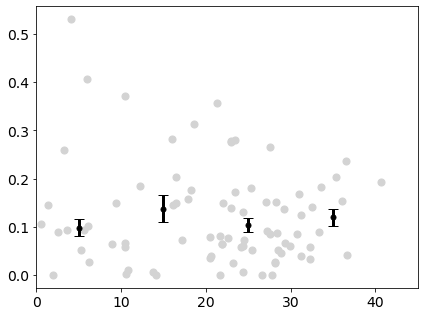

In [43]:
fig = plt.figure(figsize=(6, 4.5))
# angles_low = np.array([0, 15, 25, 35])
# angles_high = np.array([10, 25, 35, 45])
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 40])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

Mp_subsets = []
Mp_means = np.zeros(n_angles)
Mp_std = np.zeros(n_angles)
Mp_sem = np.zeros(n_angles)
for i in range(n_angles):
    Mp_subset = M0_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    L_subset = L_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    if i ==0:
        Mp_subset = np.delete(Mp_subset, 3)
        Mp_subset = np.delete(Mp_subset, 2)
    
    Mp_subsets.append(Mp_subset)
    Mp_means[i] = np.mean(Mp_subset)
    Mp_std[i] = np.std(Mp_subset)
    Mp_sem[i] = np.std(Mp_subset)/np.sqrt(len(Mp_subset))
        
# M0_arr = np.delete(M0_arr, 17)
# M0_arr = np.delete(M0_arr, 15)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 17)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 15)

plt.scatter(PP_K_angle_arr, M0_arr, 50, color='lightgray')

for i in range(n_angles):
    plt.errorbar(angles_avg[i], Mp_means[i], yerr = Mp_sem[i], elinewidth = 3, fmt = '_', \
                 color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)
    
labels = []
for i in range(n_angles):
    labels.append(str(angles_low[i]) + '-' + str(angles_high[i]))

# plt.xlabel(r'rotation angle, $\alpha_{\rm PK}$ [degrees]', fontsize = 14)
# plt.ylabel(r'moment at the pole, $M_p$ [pN$\times$μm]', fontsize = 14)
plt.xticks([0,10,20,30,40], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,45)
plt.tight_layout()
# if save_images:
plt.savefig('fig_outputs/Mp_vs_rotation_angle.pdf')

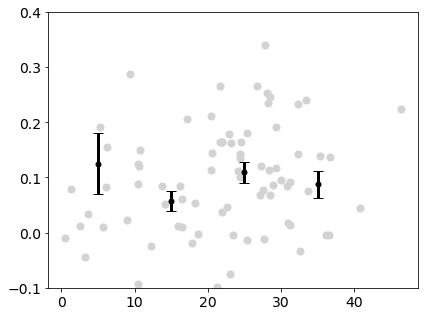

In [44]:
PP_K_angle_arr = df["PP-K angle (deg)"].values
fig = plt.figure(figsize=(6, 4.5))
# angles_low = np.array([0, 15, 25, 35])
# angles_high = np.array([10, 25, 35, 45])
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 40])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

Rx_subsets = []
Rx_means = np.zeros(n_angles)
Rx_std = np.zeros(n_angles)
Rx_sem = np.zeros(n_angles)
for i in range(n_angles):
    Rx_subset = Rx_arr[(PP_K_angle_arr >= angles_low[i]) & (PP_K_angle_arr < angles_high[i])]
    if i ==0:
        Rx_subset = np.delete(Rx_subset, 3)
        Rx_subset = np.delete(Rx_subset, 2)
    Rx_subsets.append(Rx_subset)
    Rx_means[i] = np.mean(Rx_subset)
    Rx_std[i] = np.std(Rx_subset)
    Rx_sem[i] = np.std(Rx_subset)/np.sqrt(len(Rx_subset))

# Rx_arr = np.delete(Rx_arr, 17)
# Rx_arr = np.delete(Rx_arr, 15)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 17)
# PP_K_angle_arr = np.delete(PP_K_angle_arr, 15)

plt.scatter(PP_K_angle_arr, Rx_arr, 50, color='lightgray')
for i in range(n_angles):
    plt.errorbar(angles_avg[i], Rx_means[i], yerr = Rx_sem[i], elinewidth = 3, fmt = '_', \
                 color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)
    
labels = []
for i in range(n_angles):
    labels.append(str(angles_low[i]) + '-' + str(angles_high[i]))

# plt.xlabel(r'rotation angle, $\alpha_{\rm PK}$ [degrees]', fontsize = 14)
# plt.ylabel(r'moment at the pole, $M_p$ [pN$\times$μm]', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,0.4)
plt.tight_layout()
# if save_images:
plt.savefig('fig_outputs/Rx_vs_rotation_angle.pdf')

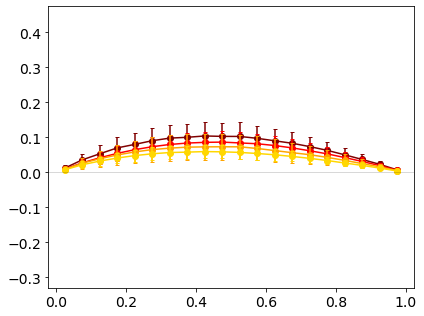

In [45]:
nbins = 20

colors=["gold", "orange", "red", "maroon", "black"]
fig = plt.figure(figsize=(6, 4.5))

for i in range(n_angles):
    
    df_angle = df[(df['PP-K angle (deg)'] >= angles_low[i]) & (df['PP-K angle (deg)'] <= angles_high[i])]
    
    rot_angle = np.mean([angles_low[i], angles_high[i]])
    
    x_mod_ls, y_mod_ls = [], []
    for n, row in df_angle.iterrows():

        x_mod = row["x (mcmc)"]
        y_mod = row["y (mcmc)"]
        L = row["L"]
        
#         x_rot, y_rot = rotate(x_mod, y_mod, np.radians(-rot_angle))
#         x_rot_scale = x_rot/L
#         y_rot_scale = y_rot/L

        x_rot, y_rot = rotate(x_mod, y_mod, np.radians(0))
        x_rot_scale = x_rot/L
        y_rot_scale = y_rot/L
        
        x_mod_ls.append(x_rot_scale)
        y_mod_ls.append(y_rot_scale)
        
        
#         plt.plot(x_rot_scale, y_rot_scale, color=colors[i], ls='--', alpha=0.2)
        
    x, y = [], []
    [x.extend(el) for el in x_mod_ls]
    [y.extend(el) for el in y_mod_ls]
    x = np.array(x)
    y = np.array(y)
    
    n, _ = np.histogram(x, bins=nbins)
    
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt = 'o-', capsize=2,color=colors[i],zorder=1-i) #colors[i])
    
plt.axhline(y=0, color="k", lw=0.5, alpha=0.3)
plt.axis("equal")
# plt.xlabel('normalized position \nparallel to the pole-pole axis', fontsize=14)
# plt.ylabel('normalized position \nnormal to the pole-pole axis', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_images:
    plt.savefig('fig_outputs/average_profiles_collapsed.pdf')

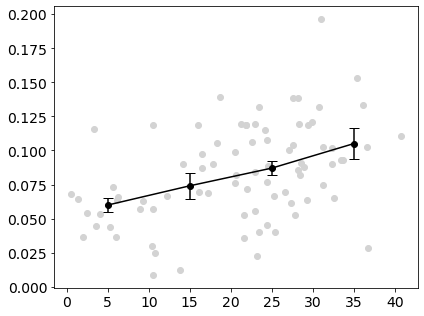

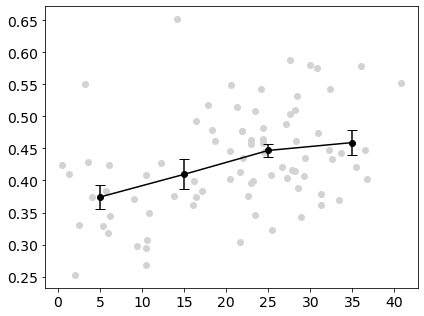

In [46]:
angles_low = np.array([0, 10, 20, 30])
angles_high = np.array([10, 20, 30, 45])
angles_avg = 0.5*(angles_low+angles_high)
n_angles = len(angles_low)

nbins = 20

colors=["gold", "orange", "red", "maroon", "black"]
maxy,angles = [],[]
L_ls,PPdist_ls,Lc_ls, ratio_ls = [],[],[],[]
Lc_mean, ymax_mean,ratio_mean,ratio_sem = [],[],[],[]
for i in range(n_angles):
    
    df_angle = df[(df['PP-K angle (deg)'] >= angles_low[i]) & (df['PP-K angle (deg)'] <= angles_high[i])]
    
    rot_angle = np.mean([angles_low[i], angles_high[i]])
#     print(rot_angle,df_angle["L"].mean(),df_angle["L"].median())
    
    x_mod_ls, y_mod_ls = [], []
    Lc_temp,maxy_temp,ratio_temp = [],[],[]
    for n, row in df_angle.iterrows():

        x_mod = row["x (mcmc)"]
        y_mod = row["y (mcmc)"]
        s,L_contour = contour_fn(x_mod,y_mod)
        L = row["L"]
        PP_dist = row["PP distance"]
        M0 = row["M0 (mcmc)"]
        Rx = row["Rx (mcmc)"]
        angle = row["PP-K angle (deg)"]
        ratio = L_contour/PP_dist
        x_rot, y_rot = rotate(x_mod, y_mod, np.radians(0))
        x_rot_scale = x_rot/L
        y_rot_scale = y_rot/L
        r = curvature(x_rot_scale,y_rot_scale,10)
        if ratio == 0.5506617009932508 and angle == 3.270438936347056:
            continue
#         print(L_contour/PP_dist,angle)
        angles.append(angle)
        maxy.append(max(y_rot_scale))
        L_ls.append(L)
        Lc_ls.append(L_contour)
        PPdist_ls.append(PP_dist)
        x_mod_ls.append(x_rot_scale)
        y_mod_ls.append(y_rot_scale)
        peak_val = np.max(y_rot_scale)
        peak_loc = x_rot_scale[y_rot_scale ==y_rot_scale.max()]
        Lc_temp.append(L_contour)
        ratio_ls.append(ratio)
        ratio_temp.append(L_contour/PP_dist)
        maxy_temp.append(max(y_rot_scale))
    Lc_mean.append(np.mean(Lc_temp))
    ymax_mean.append(np.mean(maxy_temp))
    ratio_mean.append(np.mean(ratio_temp))
    ratio_sem.append(np.std(ratio_temp)/np.sqrt(len(ratio_temp)))

angles = np.array(angles)
ratio = np.array(ratio)
maxy = np.array(maxy)
Lc_ls = np.array(Lc_ls) 
L_ls = np.array(L_ls)
PPdist_ls = np.array(PPdist_ls)
    
fig = plt.figure(figsize=(6, 4.5))
x = angles
y = maxy
plt.scatter(x, y, color='lightgray')

nbins = np.array([0,10,20,30,40])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std/np.sqrt(n), fmt='o-',color='k',capsize=5,zorder=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("fig_outputs/maxy_vs_kfibangle.pdf")
    
plt.show()

fig = plt.figure(figsize=(6, 4.5))
x = angles
y = Lc_ls/PPdist_ls
# x = np.delete(x, 17)
# y = np.delete(y, 15)

plt.scatter(x, y, color='lightgray')

nbins = np.array([0,10,20,30,45])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar([5,15,25,35], mean, yerr=std/np.sqrt(n), fmt='o-',color='k',capsize=5,zorder=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("fig_outputs/length_vs_kfibangle.pdf")
plt.show()



In [47]:
print("Lc/PP mean:", ratio_mean)
print("Lc/PP sem:", ratio_sem)


Lc/PP mean: [0.37418483467824054, 0.4095665655612051, 0.44683338657888166, 0.45911862667146547]
Lc/PP sem: [0.018787386821119658, 0.023171745004772627, 0.01074419578046872, 0.019361728240386393]


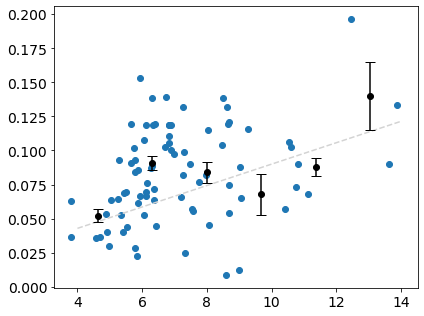

In [48]:
fig = plt.figure(figsize=(6, 4.5))
PP_dist_arr = np.delete(PP_dist_arr, 17)
PP_dist_arr = np.delete(PP_dist_arr, 15)
L_arr = np.delete(L_arr, 17)
L_arr = np.delete(L_arr, 15)

x = Lc_ls
y = maxy
plt.scatter(x,y)
fit = np.polyfit(x,y,1)
plt.plot([4,14],[fit[1], fit[0]*14 + fit[1]], color='lightgray', ls='--')

nbins = 6#np.array([3,5,7,9,11,13])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std/np.sqrt(n), fmt='o',color='k',capsize=5,zorder=10)

# plt.plot([0.3,0.4,0.5],[0.04,0.075,0.14])



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# if save_images:
#     plt.savefig("fig_outputs/length_vs_kfibangle.pdf")

In [52]:
Lc_ls

array([ 6.42128165,  5.52784214,  4.71100016,  4.8806303 ,  3.80613321,
        5.25970322,  3.79164546,  6.36986428,  9.25761898,  7.18480444,
       10.40325889, 10.7542623 ,  8.67689769, 11.12667537,  5.50779058,
        6.83522939,  6.74031528,  5.44799609,  6.99244665,  6.12441836,
        6.1128863 ,  6.28555243,  6.87607665,  4.96018062, 10.80470885,
       13.61490197,  7.30854952,  7.53761425,  8.59958655,  9.00570905,
        8.68540405,  8.45350986,  6.38260306,  8.07993571,  6.8167042 ,
        6.8167042 ,  8.02915611,  6.06039669,  5.8343036 ,  6.36159943,
        6.05439246,  7.5826365 ,  7.29600015,  6.13391157,  6.31762229,
        5.04996476,  5.66371572,  5.79301469,  5.88421963,  6.34465287,
        4.9112086 ,  6.29385406,  5.88052202,  7.74548945,  6.87814092,
        7.25769575,  7.27520978,  8.48653945,  5.34015957,  7.97352504,
        4.5583751 ,  5.64676415,  5.93343446,  6.12197402,  5.41606519,
        8.65296629, 10.53184827,  9.02218884,  8.62515226,  5.78

ValueError: x and y must be the same size

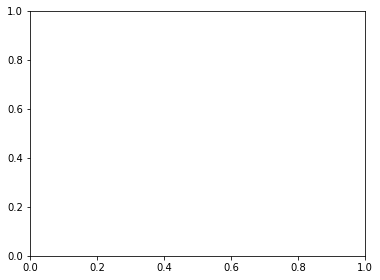

In [50]:
fig = plt.figure(figsize=(6, 4.5))
# PP_dist_arr = np.delete(PP_dist_arr, 17)
# PP_dist_arr = np.delete(PP_dist_arr, 15)
# L_arr = np.delete(L_arr, 17)
# L_arr = np.delete(L_arr, 15)

x = PP_K_angle_arr
y = ratio
plt.scatter(x,y,color='lightgray')
fit = np.polyfit(x,y,1)
plt.plot([0,45],[fit[1], fit[0]*45 + fit[1]], color='lightgray', ls='--')

nbins = np.array([0,10,20,30,40])
n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std/np.sqrt(n), fmt='o-',color='k',capsize=5,zorder=10)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# if save_images:
#     plt.savefig("fig_outputs/length_vs_kfibangle.pdf")

In [25]:
df_angle

,Kfiber,L,M0 (mcmc),M0 (small angle),PP distance,PP-K angle (deg),Pole,RMSE (mcmc),RMSE (small angle),Rx (mcmc),...,Ry (mcmc),Ry (small angle),Spindle,theta0 (mcmc),x (mcmc),x (small angle),x_dat,y (mcmc),y (small angle),y_dat
3,3,8.349459,0.085125,0.131266,14.979744,30.751129,pole_right,0.010900,0.015715,0.083638,...,0.010195,0.015722,20171215_cell004,0.372425,"[0.07560913287124293, 0.15192449983257994, 0.2...","[0.0, 0.06304163642204763, 0.12616314600420964...","[0.0, 0.06304163642204763, 0.12616314600420964...","[0.04278878977427662, 0.08481661804396595, 0.1...","[0.0, 0.03592322570985784, 0.07136367343238192...","[0.0, 0.0336266004080135, 0.06712990147177089,..."
5,1,5.775064,0.041740,0.017294,14.388300,36.674350,pole_right,0.002783,0.006178,0.136223,...,0.007228,0.002995,20171215_cell004a,0.079552,"[0.0003198906177805938, 0.05775287439424215, 0...","[0.0, 0.050978866913308885, 0.1020104280589695...","[0.0, 0.050978866913308885, 0.1020104280589695...","[-0.0029901182439205382, 0.00409351975479109, ...","[0.0, 0.005155676732896269, 0.0102690191474791...","[0.0, 0.005206638617668917, 0.0103740368495473..."
7,1,7.417120,0.034058,0.036825,13.807008,32.353020,pole_right,0.014414,0.012189,0.141780,...,0.004592,0.004965,20171215_cell005,0.268954,"[0.07064009537020954, 0.14258519608299292, 0.2...","[0.0, 0.07889266391527627, 0.1577853278305481,...","[0.0, 0.07889266391527627, 0.1577853278305481,...","[0.023361728942514166, 0.04684928126956379, 0....","[0.0, 0.025571454843647035, 0.050893148936936,...","[-0.0, 0.024824218053377187, 0.049648436106753..."
16,0,5.698907,0.182300,0.207766,13.021693,33.638214,pole_left,0.012389,0.012623,0.076310,...,0.031989,0.036457,20180612_cell003,0.249447,"[0.05140389779788279, 0.10459758359378135, 0.1...","[0.0, 0.05003988126258285, 0.10013650960655873...","[0.0, 0.05003988126258285, 0.10013650960655873...","[0.024352852959279598, 0.0482233336617341, 0.0...","[0.0, 0.02252510853174927, 0.04455593195778684...","[-0.0, 0.022143489635253602, 0.044375323872796..."
25,0,6.690610,0.192473,0.220164,12.401118,40.735071,pole_left,0.018971,0.021260,0.044557,...,0.028768,0.032906,20180622_cell020,0.290559,"[0.05643489589941364, 0.1168548889808898, 0.17...","[0.0, 0.05441058611701877, 0.10875608287315597...","[0.0, 0.05441058611701877, 0.10875608287315597...","[0.03295992970693984, 0.06645426748873308, 0.0...","[0.0, 0.029394364959280495, 0.0581054153697202...","[-0.0, 0.029408032378969544, 0.058733673161885..."
40,0,5.596855,0.203363,0.271929,14.071567,35.369847,pole_left,0.012882,0.011021,0.138308,...,0.036335,0.048586,20180622_cell030,0.417076,"[0.0004113223120052467, 0.04802922039780544, 0...","[0.0, 0.0558552791090996, 0.11173321156715943,...","[0.0, 0.0558552791090996, 0.11173321156715943,...","[-0.0006915119178435639, 0.03465914502087859, ...","[0.0, 0.038640903601311116, 0.0764429946720608...","[-0.0, 0.03431489903299351, 0.0684830437618573..."
43,1,5.175456,0.089030,0.092375,14.286175,33.402470,pole_left,0.003772,0.006553,0.241120,...,0.017202,0.017849,20180626_cell001,0.269660,"[0.0011254895057541958, 0.050653473431400364, ...","[0.0, 0.05617547543950163, 0.11249722642322801...","[0.0, 0.05617547543950163, 0.11249722642322801...","[-0.003232826588826631, 0.015284523280310141, ...","[0.0, 0.02029583424174436, 0.04033913917388437...","[-0.0, 0.01840951409315181, 0.0368445911509541..."
49,0,5.654423,0.058323,0.065641,12.811721,32.267884,pole_left,0.015012,0.009520,0.233135,...,0.010315,0.011609,20180628_cell010,0.301217,"[0.053736158563517655, 0.10798165415832095, 0....","[0.0, 0.06294347752383178, 0.12588695504766356...","[0.0, 0.06294347752383178, 0.12588695504766356...","[0.019843895295751018, 0.04040437654375149, 0....","[0.0, 0.023640901476599308, 0.0470024657106731...","[-0.0, 0.020812176416869086, 0.041624352833738..."
56,3,6.587564,0.235980,0.276713,15.015367,36.539763,pole_right,0.019231,0.017993,-0.004652,...,0.035822,0.042005,20180628_cell013,0.259942,"[0.05668330327948112, 0.1158840424750353

In [26]:
df_angle

,Kfiber,L,M0 (mcmc),M0 (small angle),PP distance,PP-K angle (deg),Pole,RMSE (mcmc),RMSE (small angle),Rx (mcmc),...,Ry (mcmc),Ry (small angle),Spindle,theta0 (mcmc),x (mcmc),x (small angle),x_dat,y (mcmc),y (small angle),y_dat
3,3,8.349459,0.085125,0.131266,14.979744,30.751129,pole_right,0.010900,0.015715,0.083638,...,0.010195,0.015722,20171215_cell004,0.372425,"[0.07560913287124293, 0.15192449983257994, 0.2...","[0.0, 0.06304163642204763, 0.12616314600420964...","[0.0, 0.06304163642204763, 0.12616314600420964...","[0.04278878977427662, 0.08481661804396595, 0.1...","[0.0, 0.03592322570985784, 0.07136367343238192...","[0.0, 0.0336266004080135, 0.06712990147177089,..."
5,1,5.775064,0.041740,0.017294,14.388300,36.674350,pole_right,0.002783,0.006178,0.136223,...,0.007228,0.002995,20171215_cell004a,0.079552,"[0.0003198906177805938, 0.05775287439424215, 0...","[0.0, 0.050978866913308885, 0.1020104280589695...","[0.0, 0.050978866913308885, 0.1020104280589695...","[-0.0029901182439205382, 0.00409351975479109, ...","[0.0, 0.005155676732896269, 0.0102690191474791...","[0.0, 0.005206638617668917, 0.0103740368495473..."
7,1,7.417120,0.034058,0.036825,13.807008,32.353020,pole_right,0.014414,0.012189,0.141780,...,0.004592,0.004965,20171215_cell005,0.268954,"[0.07064009537020954, 0.14258519608299292, 0.2...","[0.0, 0.07889266391527627, 0.1577853278305481,...","[0.0, 0.07889266391527627, 0.1577853278305481,...","[0.023361728942514166, 0.04684928126956379, 0....","[0.0, 0.025571454843647035, 0.050893148936936,...","[-0.0, 0.024824218053377187, 0.049648436106753..."
16,0,5.698907,0.182300,0.207766,13.021693,33.638214,pole_left,0.012389,0.012623,0.076310,...,0.031989,0.036457,20180612_cell003,0.249447,"[0.05140389779788279, 0.10459758359378135, 0.1...","[0.0, 0.05003988126258285, 0.10013650960655873...","[0.0, 0.05003988126258285, 0.10013650960655873...","[0.024352852959279598, 0.0482233336617341, 0.0...","[0.0, 0.02252510853174927, 0.04455593195778684...","[-0.0, 0.022143489635253602, 0.044375323872796..."
25,0,6.690610,0.192473,0.220164,12.401118,40.735071,pole_left,0.018971,0.021260,0.044557,...,0.028768,0.032906,20180622_cell020,0.290559,"[0.05643489589941364, 0.1168548889808898, 0.17...","[0.0, 0.05441058611701877, 0.10875608287315597...","[0.0, 0.05441058611701877, 0.10875608287315597...","[0.03295992970693984, 0.06645426748873308, 0.0...","[0.0, 0.029394364959280495, 0.0581054153697202...","[-0.0, 0.029408032378969544, 0.058733673161885..."
40,0,5.596855,0.203363,0.271929,14.071567,35.369847,pole_left,0.012882,0.011021,0.138308,...,0.036335,0.048586,20180622_cell030,0.417076,"[0.0004113223120052467, 0.04802922039780544, 0...","[0.0, 0.0558552791090996, 0.11173321156715943,...","[0.0, 0.0558552791090996, 0.11173321156715943,...","[-0.0006915119178435639, 0.03465914502087859, ...","[0.0, 0.038640903601311116, 0.0764429946720608...","[-0.0, 0.03431489903299351, 0.0684830437618573..."
43,1,5.175456,0.089030,0.092375,14.286175,33.402470,pole_left,0.003772,0.006553,0.241120,...,0.017202,0.017849,20180626_cell001,0.269660,"[0.0011254895057541958, 0.050653473431400364, ...","[0.0, 0.05617547543950163, 0.11249722642322801...","[0.0, 0.05617547543950163, 0.11249722642322801...","[-0.003232826588826631, 0.015284523280310141, ...","[0.0, 0.02029583424174436, 0.04033913917388437...","[-0.0, 0.01840951409315181, 0.0368445911509541..."
49,0,5.654423,0.058323,0.065641,12.811721,32.267884,pole_left,0.015012,0.009520,0.233135,...,0.010315,0.011609,20180628_cell010,0.301217,"[0.053736158563517655, 0.10798165415832095, 0....","[0.0, 0.06294347752383178, 0.12588695504766356...","[0.0, 0.06294347752383178, 0.12588695504766356...","[0.019843895295751018, 0.04040437654375149, 0....","[0.0, 0.023640901476599308, 0.0470024657106731...","[-0.0, 0.020812176416869086, 0.041624352833738..."
56,3,6.587564,0.235980,0.276713,15.015367,36.539763,pole_right,0.019231,0.017993,-0.004652,...,0.035822,0.042005,20180628_cell013,0.259942,"[0.05668330327948112, 0.1158840424750353

In [27]:
df_MkMpnonzero = pd.read_pickle("noforce_MkMpnonzero.pkl")

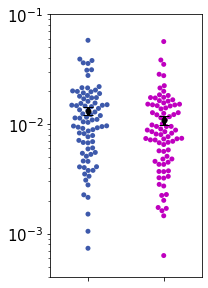

mann-whitney U test
0.09561487720885056


In [28]:
RMSE_Mkzero_ls = df["RMSE (mcmc)"].values
RMSE_MkMpnonzero_ls = df_MkMpnonzero["RMSE (mcmc)"].values

plt.figure(figsize=(3,4))
seed = 4
np.random.seed(seed)

var1 = RMSE_Mkzero_ls
var2 = RMSE_MkMpnonzero_ls

plt.yscale("log")

sns.swarmplot(data=[var1,var2], palette = ["#3D59AB","m"], size = 5)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("","","",""),fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.ylim(0.0004,0.1)
# plt.gca().invert_yaxis()

if save_images:
    plt.savefig('fig_outputs/MkMpnonzero_RMSE.pdf')
plt.show()

from scipy.stats import mannwhitneyu
print("mann-whitney U test")
print(mannwhitneyu(RMSE_Mkzero_ls, RMSE_MkMpnonzero_ls, alternative='two-sided')[1])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


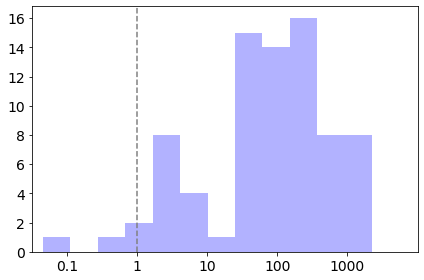

In [29]:
Rx = df_MkMpnonzero["Rx (mcmc)"].mean()
Ry = df_MkMpnonzero["Ry (mcmc)"].mean()
M0 = df_MkMpnonzero["M0 (mcmc)"].mean()

Mk_ls = []
for index, row in df_MkMpnonzero.iterrows():
    Mk_ls.append(row["M0 (mcmc)"] - (row["Ry (mcmc)"]*row["L"]))
Mk = np.mean(Mk_ls)

plt.hist(np.log10(df_MkMpnonzero["M0 (mcmc)"].values/np.array(Mk_ls)),bins=20,color='b',alpha=0.3);
plt.xticks([-1,0,1,2,3], [0.1,1,10,100,1000],fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(0,color='grey',ls='--')
plt.xlim(-1.5,4)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/M0Mkratio.pdf")
plt.show()

In [30]:
print(np.mean(df["RMSE (exact)"].values))
print(np.mean(df["RMSE (mcmc)"].values))

KeyError: 'RMSE (exact)'

In [31]:
print(np.mean(df_MkMpnonzero["RMSE (exact)"].values))
print(np.mean(df_MkMpnonzero["RMSE (mcmc)"].values))

0.009653639839973853
0.010860645357657451


<ErrorbarContainer object of 3 artists>

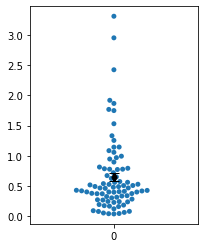

In [32]:
x_SA_arr = df["x (small angle)"].values
y_SA_arr = df["y (small angle)"].values
x_exact_arr = df["x (mcmc)"].values
y_exact_arr = df["y (mcmc)"].values
err_exact = df['RMSE (mcmc)'].values

plt.figure(figsize=(3,4))

err_bw_mods = []
for i in range(len(x_SA_arr)):
    x_SA = x_SA_arr[i]
    y_SA = y_SA_arr[i]
    x_exact = x_exact_arr[i]
    y_exact = y_exact_arr[i]
    res = distances_pair_min_new(x_SA, y_SA, x_exact, y_exact)
    err_bw_mods.append(np.sqrt(np.mean(res**2)))
err_bw_mods = np.array(err_bw_mods)

# plt.yscale("log")
var = err_bw_mods/err_exact
sns.swarmplot(data=var, size = 5)
plt.errorbar([0],np.mean(var),yerr = np.std(var)/np.sqrt(len(var)),\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)
# plt.ylim(0,1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


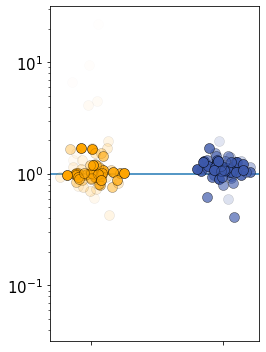

In [33]:
df = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")

Rx_SA = df["Rx (small angle)"].values
M0_SA = df["M0 (small angle)"].values
Ry_SA = df["Ry (small angle)"].values

Rx_exact = df["Rx (mcmc)"].values
M0_exact = df["M0 (mcmc)"].values
Ry_exact = df["Ry (mcmc)"].values

L = df["L"].values
y = df["y (mcmc)"].values
y_max = np.array([np.max(elem) for elem in y])

w_Rx = np.abs(Rx_exact*y_max)
w_M0 = np.abs(M0_exact)
Z = (w_Rx + w_M0)

plt.figure(figsize=(3.8,5))

var1 = Rx_SA/Rx_exact
var2 = M0_SA/M0_exact

seed = 4
np.random.seed(seed)
x1 = np.random.normal(0.5,0.1,len(var1))
x2 = np.random.normal(1.5,0.1,len(var2))

plt.yscale("log")
for i in range(len(var1)):
    plt.scatter(x1[i],var1[i],color="orange",edgecolor='k',lw=0.5, s=100, alpha=w_Rx[i]/Z[i],zorder=10)
    plt.scatter(x2[i],var2[i],color='#3D59AB',edgecolor='k',lw=0.5,s=100, alpha=w_M0[i]/Z[i],zorder=10)

plt.yticks([1e-1, 1e0, 1e1])
plt.ylim([10**-1.5, 10**1.5])

plt.xticks([0.5,1.5], ("",""),fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.axhline(1)


plt.savefig('fig_outputs/small_vs_exact_ratios.pdf')
plt.show()

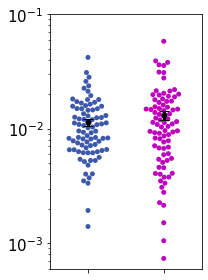

In [34]:
err_SA = df["RMSE (small angle)"].values
err_exact = df["RMSE (mcmc)"].values
diff_model_err = np.abs(err_SA - err_exact)/err_exact

plt.figure(figsize=(3,4))

var1 = err_SA
var2 = err_exact
plt.yscale("log")

sns.swarmplot(data=[var1,var2], palette = ["#3D59AB","m"], size = 5)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
             yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],\
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, \
             capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("",""),fontsize=15)
plt.yticks([1e-3, 1e-2, 1e-1], fontsize=15)

plt.tight_layout()

plt.savefig('fig_outputs/smallangle_approx_errors.pdf')
plt.show()